# Quantitative Finance- <a class = "anchor" id = "top"></a>

## Algorithmic Stock Trading of S&P 500
---

By: DataGuy


Table of Contents:

-[Setup](#setup)

-[Algorithmic Trading](#eda)

-[Visualization](#viz)

---

### Setup <a class = "anchor" id = "setup"></a>

In [14]:
# Import libraries
import pandas as pd
import pandas_datareader as pdr
import time
from multiprocessing import Pool, cpu_count
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read tickers
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
tickers = table[0]
symbols = tickers['Symbol'].unique()

In [3]:
tickers.head(n = 10)

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
5,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
6,ATVI,Activision Blizzard,reports,Communication Services,Interactive Home Entertainment,"Santa Monica, California",2015-08-31,718877,2008
7,ADM,ADM,reports,Consumer Staples,Agricultural Products,"Chicago, Illinois",1981-07-29,7084,1902
8,ADBE,Adobe Inc.,reports,Information Technology,Application Software,"San Jose, California",1997-05-05,796343,1982
9,ADP,ADP,reports,Information Technology,Data Processing & Outsourced Services,"Roseland, New Jersey",1981-03-31,8670,1949


In [4]:
# Init
num_cpu = cpu_count()

In [5]:
# Function to get price
def get_ticker_data(symbol):
    
    try:
    
        data = pdr.get_data_yahoo(symbol, '2020-01-01', '2022-10-13').rename({'Adj Close': 'price'}, axis = 1)[['price']]

        # Calculate
        data['ticker'] = symbol
        data['daily_pct_change'] = data['price'] / data['price'].shift(1) - 1
        data['daily_pct_change'].fillna(0, inplace = True)
        data['cum_daily_return'] = (1 + data['daily_pct_change']).cumprod()
        data['short'] = data['price'].rolling(30).mean()
        data['long'] = data['price'].rolling(90).mean()

        return data
    
    except:
    
        return None

# Function to perform backtesting
def perform_backtesting(nm):
    
    grp = df2.loc[df2['ticker'] == nm]
    
    positions[nm] = 1000 * grp['signal'] 

    port = positions.multiply(grp['price'], axis = 0)
    pos_diff = positions.diff()

    # Add `holdings` to portfolio
    port['holdings'] = (positions.multiply(grp['price'], axis = 0)).sum(axis = 1)
    
    # Add `cash` to portfolio
    port['cash'] = 10000 - (pos_diff.multiply(grp['price'], axis = 0)).sum(axis = 1).cumsum()   

    # Add `total` to portfolio
    port['total'] = port['cash'] + port['holdings']
    
    # Add `returns` to portfolio
    port['returns'] = port['total'].pct_change() 
    
    port['ticker'] = nm
        
    return port

[Back to top..](top)

### Algorithmic Trading <a class = "anchor" id = "eda"></a>

In [6]:
# Iterate tickers to retrieve prices
start = time.time()
pool = Pool(num_cpu - 1)
result = pool.map(get_ticker_data, symbols)    
end = time.time()
print(f'Elapsed data retrieval time: {round((end - start)/60, 2)} minutes..')

Elapsed data retrieval time: 1.2 minutes..


In [7]:
df = pd.concat([i for i in result])
df1 = df.dropna()
df2 = pd.DataFrame()
portfolio = pd.DataFrame()

In [8]:
df.head()

,price,ticker,daily_pct_change,cum_daily_return,short,long
Date,,,,,,
2020-01-02,166.588959,MMM,0.000000,1.000000,NaN,NaN
2020-01-03,165.154465,MMM,-0.008611,0.991389,NaN,NaN
2020-01-06,165.311783,MMM,0.000953,0.992333,NaN,NaN
2020-01-07,164.645416,MMM,-0.004031,0.988333,NaN,NaN
2020-01-08,167.172028,MMM,0.015346,1.003500,NaN,NaN


In [9]:
# Iterate
for nm, grp in df1.groupby('ticker'):
    
    # Handle exceptions
    try:
        
        # Calculate trades
        grp['signal'] = 0
        grp['signal'][30:] = np.where(grp['short'][30:] > grp['long'][30:], 1.0, 0.0)   
        grp['positions'] = grp['signal'].diff()
    
        df2 = df2.append(grp)
        
    except:
        
        print(f'Error for {nm}..')

In [10]:
df2.head()

,price,ticker,daily_pct_change,cum_daily_return,short,long,signal,positions
Date,,,,,,,,
2020-05-11,80.386368,A,0.019571,0.947956,75.055630,78.029656,0,NaN
2020-05-12,78.981804,A,-0.017473,0.931393,75.292361,77.965013,0,0.0
2020-05-13,79.288429,A,0.003882,0.935009,75.573933,77.918905,0,0.0
2020-05-14,80.752342,A,0.018463,0.952272,75.993323,77.886322,0,0.0
2020-05-15,80.702888,A,-0.000612,0.951689,76.299953,77.850340,0,0.0


In [11]:
# Backtesting
for nm, grp in df2.groupby('ticker'):
    
    positions = pd.DataFrame(index = grp.index).fillna(0.0)
    positions[nm] = 1000 * grp['signal'] 

    port = positions.multiply(grp['price'], axis = 0)
    pos_diff = positions.diff()

    # Add `holdings` to portfolio
    port['holdings'] = (positions.multiply(grp['price'], axis = 0)).sum(axis = 1)

    # Add `cash` to portfolio
    port['cash'] = 10000 - (pos_diff.multiply(grp['price'], axis = 0)).sum(axis = 1).cumsum()   

    # Add `total` to portfolio
    port['total'] = port['cash'] + port['holdings']

    # Add `returns` to portfolio
    port['returns'] = port['total'].pct_change() 
    
    port['ticker'] = nm
    
    portfolio = portfolio.append(port)

In [12]:
# Sum across portfolio
agg_portfolio = portfolio.groupby(portfolio.index)['holdings', 'cash', 'total'].agg({'holdings': 'sum',
                                                                                     'cash': 'sum',
                                                                                     'total': 'sum'}, axis = 1)


In [13]:
agg_portfolio.tail()

,holdings,cash,total
Date,,,
2022-10-07,2.507377e+07,-1.197071e+07,1.310306e+07
2022-10-10,2.423132e+07,-1.121389e+07,1.301743e+07
2022-10-11,2.317358e+07,-1.023475e+07,1.293883e+07
2022-10-12,2.196422e+07,-9.206111e+06,1.275811e+07
2022-10-13,2.493859e+07,-1.169828e+07,1.324031e+07


[Back to top..](top)

### Visualization <a class = "anchor" id = "viz"></a>

Text(0, 0.5, 'Total Portfolio $ (Million)')

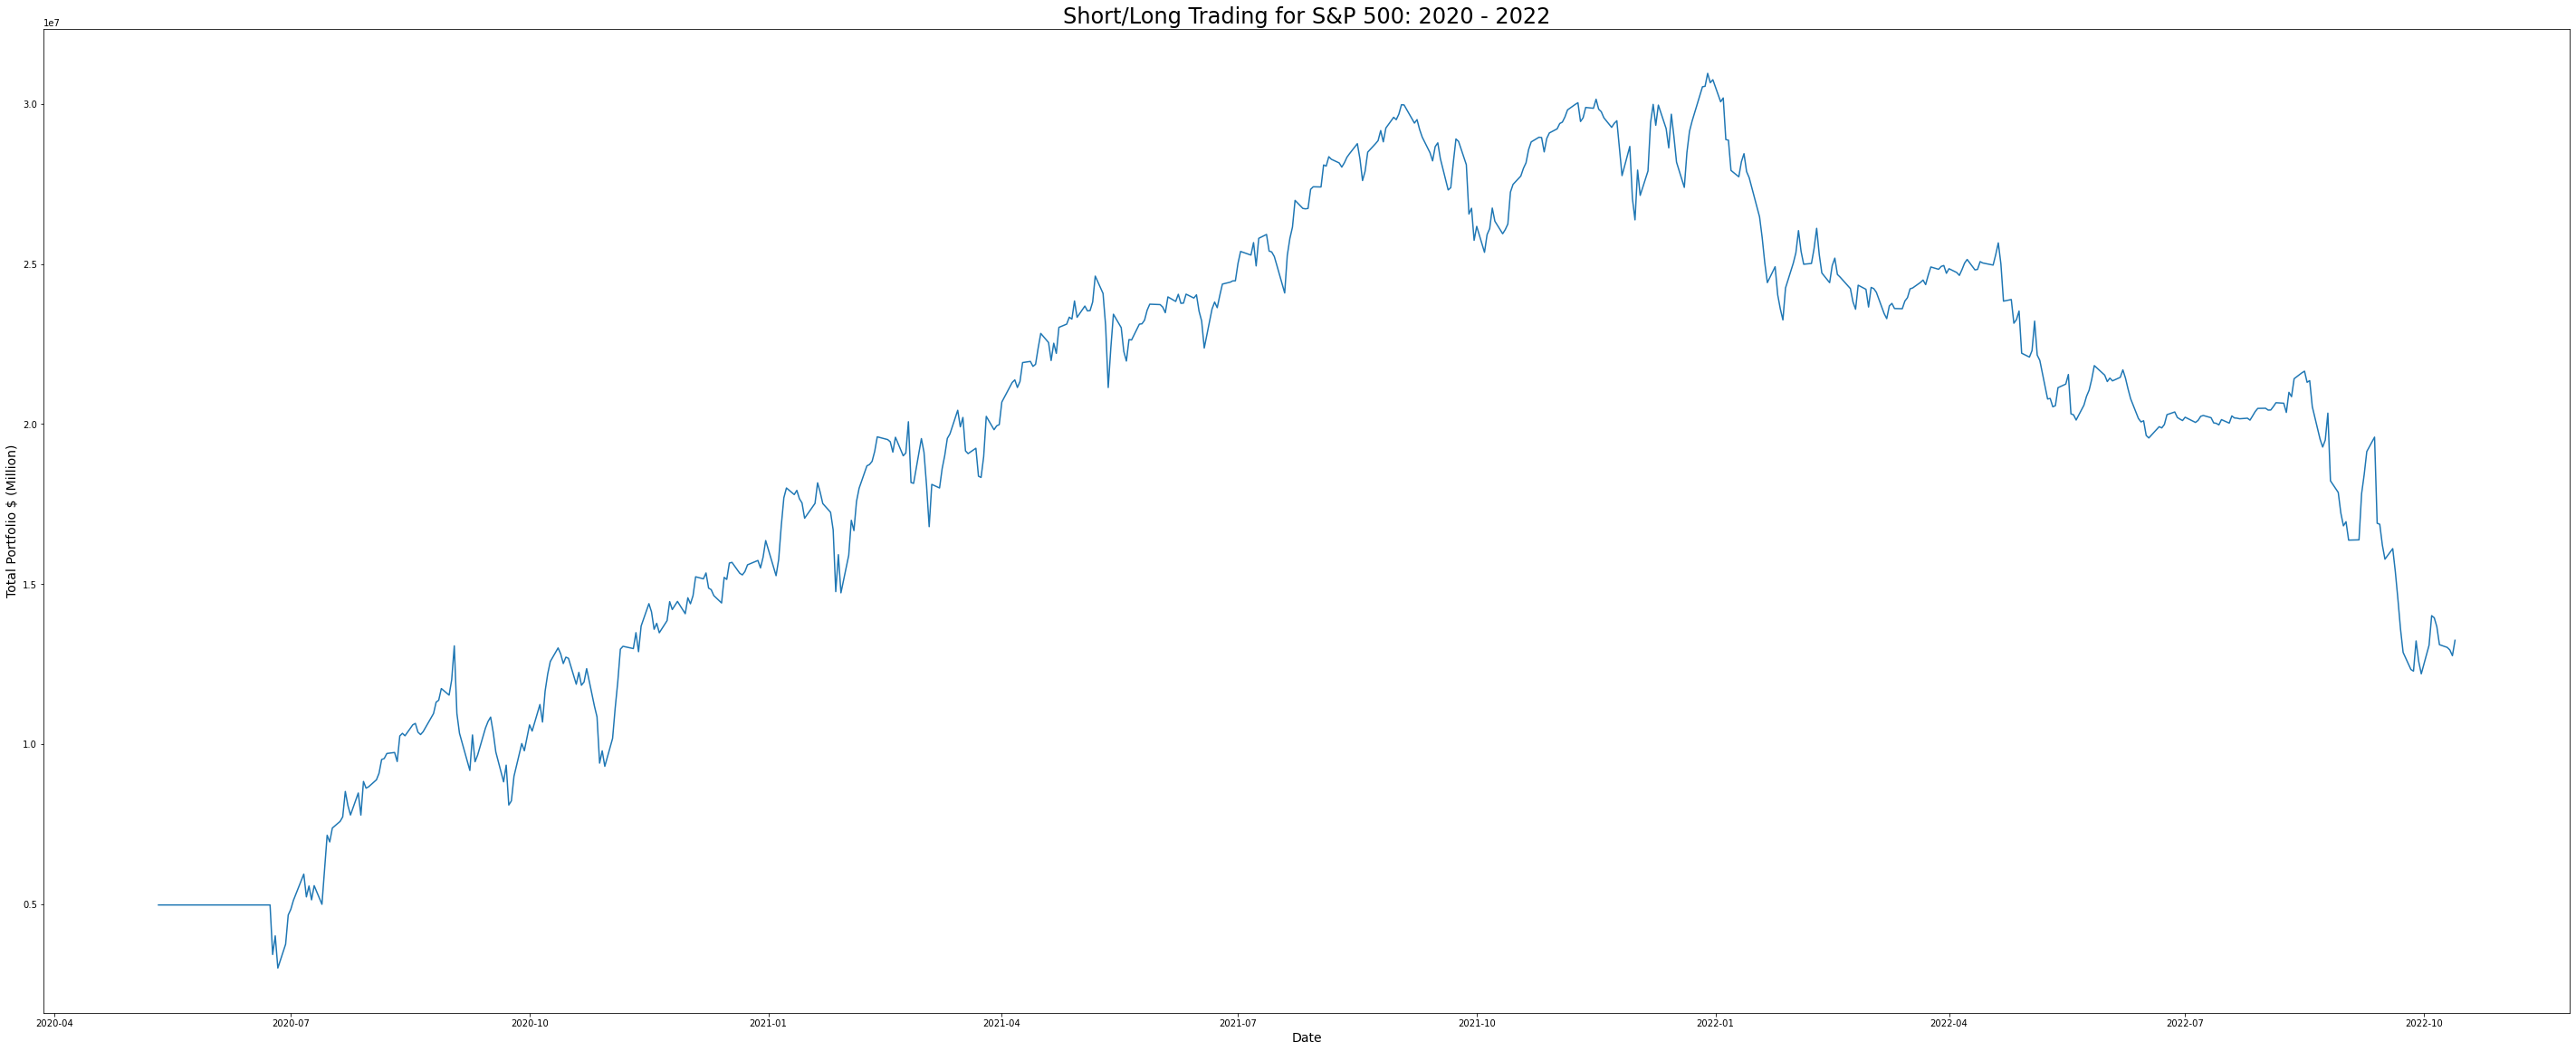

In [22]:
plt.figure(figsize = (50, 20))
plt.plot(agg_portfolio['total'])
plt.title('Short/Long Trading for S&P 500: 2020 - 2022', fontsize = 24)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Total Portfolio $ (Million)', fontsize = 14)

[Back to top..](#top)